In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import math
import copy

In [2]:
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Flatten, Dropout, Activation, Lambda, Permute, Reshape
from keras.layers import Convolution2D, ZeroPadding2D, MaxPooling2D

Using TensorFlow backend.


## This notebook as been tested with Keras 2 and TensorFlow

In [3]:
from keras import backend as K
K.set_image_data_format( 'channels_last' ) # WARNING : important for images and tensors dimensions ordering

## Build model architecture

In [4]:
def convblock(cdim, nb, bits=3):
    L = []
    
    for k in range(1,bits+1):
        convname = 'conv'+str(nb)+'_'+str(k)
        #L.append( Convolution2D(cdim, 3, 3, border_mode='same', activation='relu', name=convname) ) # Keras 1
        L.append( Convolution2D(cdim, kernel_size=(3, 3), padding='same', activation='relu', name=convname) ) # Keras 2
    
    L.append( MaxPooling2D((2, 2), strides=(2, 2)) )
    
    return L

In [5]:
def vgg_face_blank():
    
    withDO = True # no effect during evaluation but usefull for fine-tuning
    
    if True:
        mdl = Sequential()
        
        # First layer is a dummy-permutation = Identity to specify input shape
        mdl.add( Permute((1,2,3), input_shape=(224,224,3)) ) # WARNING : 0 is the sample dim

        for l in convblock(64, 1, bits=2):
            mdl.add(l)

        for l in convblock(128, 2, bits=2):
            mdl.add(l)
        
        for l in convblock(256, 3, bits=3):
            mdl.add(l)
            
        for l in convblock(512, 4, bits=3):
            mdl.add(l)
            
        for l in convblock(512, 5, bits=3):
            mdl.add(l)
        
        #mdl.add( Convolution2D(4096, 7, 7, activation='relu', name='fc6') ) # Keras 1
        mdl.add( Convolution2D(4096, kernel_size=(7, 7), activation='relu', name='fc6') ) # Keras 2
        if withDO:
            mdl.add( Dropout(0.5) )
        #mdl.add( Convolution2D(4096, 1, 1, activation='relu', name='fc7') ) # Keras 1
        mdl.add( Convolution2D(4096, kernel_size=(1, 1), activation='relu', name='fc7') ) # Keras 2
        if withDO:
            mdl.add( Dropout(0.5) )
        #mdl.add( Convolution2D(2622, 1, 1, name='fc8') ) # Keras 1
        mdl.add( Convolution2D(2622, kernel_size=(1, 1), activation='relu', name='fc8') ) # Keras 2
        mdl.add( Flatten() )
        mdl.add( Activation('softmax') )
        
        return mdl
    
    else:
        # See following link for a version based on Keras functional API :
        # gist.github.com/EncodeTS/6bbe8cb8bebad7a672f0d872561782d9
        raise ValueError('not implemented')

In [6]:
# Reference : https://github.com/rcmalli/keras-vggface
# Reference : gist.github.com/EncodeTS/6bbe8cb8bebad7a672f0d872561782d9

In [7]:
facemodel = vgg_face_blank()

In [8]:
facemodel.summary() # visual inspection of model architecture

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
permute_1 (Permute)          (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 224, 224, 64)      1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 112, 112, 128)     147584    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 56, 56, 128)       0         
__________

## Load VGG weigths from .mat file

#### http://www.vlfeat.org/matconvnet/pretrained/#face-recognition
##### Download from console with :
wget http://www.vlfeat.org/matconvnet/models/vgg-face.mat

##### Alternatively :
wget http://www.robots.ox.ac.uk/~vgg/software/vgg_face/src/vgg_face_matconvnet.tar.gz

In [9]:
from scipy.io import loadmat

In [12]:
if False: # INFO : use this if you downloaded weights from vlfeat.org
    data = loadmat('vgg-face.mat', matlab_compatible=False, struct_as_record=False)
    l = data['layers']
    description = data['meta'][0,0].classes[0,0].description
else: # INFO : use this if you downloaded weights from robots.ox.ac.uk
    data = loadmat('vgg_face_matconvnet/data/vgg_face.mat', matlab_compatible=False, struct_as_record=False)
    net = data['net'][0,0]
    l = net.layers
    description = net.classes[0,0].description

In [13]:
l.shape, description.shape

((1, 39), (2622, 1))

In [14]:
l[0,10][0,0].type[0], l[0,10][0,0].name[0]

('conv', 'conv3_1')

In [15]:
l[0,10][0,0].weights[0,0].shape, l[0,10][0,0].weights[0,1].shape

((3, 3, 128, 256), (256, 1))

In [34]:
def weight_compare(kmodel):
    kerasnames = [lr.name for lr in kmodel.layers]

    # WARNING : important setting as 2 of the 4 axis have same size dimension
    #prmt = (3,2,0,1) # INFO : for 'th' setting of 'dim_ordering'
    prmt = (0,1,2,3) # INFO : for 'channels_last' setting of 'image_data_format'

    for i in range(l.shape[1]):
        matname = l[0,i][0,0].name[0]
        mattype = l[0,i][0,0].type[0]
        if matname in kerasnames:
            kindex = kerasnames.index(matname)
            print(matname, mattype)
            print(l[0,i][0,0].weights[0,0].transpose(prmt).shape, l[0,i][0,0].weights[0,1].shape)
            print(kmodel.layers[kindex].get_weights()[0].shape, kmodel.layers[kindex].get_weights()[1].shape)
            print('------------------------------------------')
        else:
            print('MISSING : ', matname, mattype)
            print('------------------------------------------')

In [35]:
#weight_compare(facemodel)

In [36]:
def copy_mat_to_keras(kmodel):

    kerasnames = [lr.name for lr in kmodel.layers]

    # WARNING : important setting as 2 of the 4 axis have same size dimension
    #prmt = (3,2,0,1) # INFO : for 'th' setting of 'dim_ordering'
    prmt = (0,1,2,3) # INFO : for 'channels_last' setting of 'image_data_format'

    for i in range(l.shape[1]):
        matname = l[0,i][0,0].name[0]
        if matname in kerasnames:
            kindex = kerasnames.index(matname)
            #print matname
            l_weights = l[0,i][0,0].weights[0,0]
            l_bias = l[0,i][0,0].weights[0,1]
            f_l_weights = l_weights.transpose(prmt)
            #f_l_weights = np.flip(f_l_weights, 2) # INFO : for 'th' setting in dim_ordering
            #f_l_weights = np.flip(f_l_weights, 3) # INFO : for 'th' setting in dim_ordering
            assert (f_l_weights.shape == kmodel.layers[kindex].get_weights()[0].shape)
            assert (l_bias.shape[1] == 1)
            assert (l_bias[:,0].shape == kmodel.layers[kindex].get_weights()[1].shape)
            assert (len(kmodel.layers[kindex].get_weights()) == 2)
            kmodel.layers[kindex].set_weights([f_l_weights, l_bias[:,0]])
            #print '------------------------------------------'

In [37]:
copy_mat_to_keras(facemodel)

### Test on squared and well centered image

In [38]:
im = Image.open('ak.png') # WARNING : this image is well centered and square
im = im.resize((224,224))

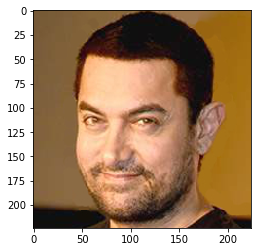

In [39]:
plt.imshow(np.asarray(im))

In [41]:
def pred(kmodel, crpimg, transform=False):
    
    # transform=True seems more robust but I think the RGB channels are not in right order
    
    imarr = np.array(crpimg).astype(np.float32)

    if transform:
        imarr[:,:,0] -= 129.1863
        imarr[:,:,1] -= 104.7624
        imarr[:,:,2] -= 93.5940
        #
        # WARNING : in this script (https://github.com/rcmalli/keras-vggface) colours are switched
        aux = copy.copy(imarr)
        #imarr[:, :, 0] = aux[:, :, 2]
        #imarr[:, :, 2] = aux[:, :, 0]

        #imarr[:,:,0] -= 129.1863
        #imarr[:,:,1] -= 104.7624
        #imarr[:,:,2] -= 93.5940

    #imarr = imarr.transpose((2,0,1)) # INFO : for 'th' setting of 'dim_ordering'
    imarr = np.expand_dims(imarr, axis=0)

    out = kmodel.predict(imarr)

    best_index = np.argmax(out, axis=1)[0]
    best_name = description[best_index,0]
    print(best_index, best_name[0], out[0,best_index], [np.min(out), np.max(out)])

In [42]:
crpim = im # WARNING : we deal with cropping in a latter section, this image is already fit

pred(facemodel, crpim, transform=False)
pred(facemodel, crpim, transform=True)

2 Aamir_Khan 0.994433 [9.4759907e-09, 0.99443275]
2 Aamir_Khan 0.944453 [2.2034849e-06, 0.94445282]


In [43]:
[(i, s[0]) for i, s in enumerate(description[:,0]) if ('laurie'.lower() in s[0].lower())]

[(861, 'Hugh_Laurie'), (1445, 'Laurie_Holden')]

In [44]:
description[100,0][0]

'America_Ferrera'

## Face Feature Vector : drop the last layer

In [30]:
featuremodel = Model(inputs=facemodel.layers[0].input, outputs=facemodel.layers[-2].output)

In [31]:
def features(featmodel, crpimg, transform=False):
    
    # transform=True seems more robust but I think the RGB channels are not in right order
    
    imarr = np.array(crpimg).astype(np.float32)

    if transform:
        imarr[:,:,0] -= 129.1863
        imarr[:,:,1] -= 104.7624
        imarr[:,:,2] -= 93.5940
        #
        # WARNING : in this script (https://github.com/rcmalli/keras-vggface) colours are switched
        aux = copy.copy(imarr)
        #imarr[:, :, 0] = aux[:, :, 2]
        #imarr[:, :, 2] = aux[:, :, 0]

        #imarr[:,:,0] -= 129.1863
        #imarr[:,:,1] -= 104.7624
        #imarr[:,:,2] -= 93.5940

    #imarr = imarr.transpose((2,0,1))
    imarr = np.expand_dims(imarr, axis=0)

    fvec = featmodel.predict(imarr)[0,:]
    # normalize
    normfvec = math.sqrt(fvec.dot(fvec))
    return fvec/normfvec

In [32]:
f = features(featuremodel, crpim, transform=True)

In [33]:
f.shape, f.dot(f)

((2622,), 1.0)

## Face extraction + Face identification
#### This requires OpenCV :
https://pypi.python.org/pypi/opencv-python
#### See this tutorial on face CascadeClassifier :
https://realpython.com/blog/python/face-recognition-with-python/

In [52]:
import cv2

ImportError: No module named 'cv2'

In [27]:
imagePath = 'Aamir_Khan.jpg'
#imagePath = 'mzaradzki.jpg'
#imagePath = 'hugh_laurie.jpg'
#imagePath = 'Colin_Firth.jpg'
#imagePath = 'someguy.jpg'

Found 1 faces!


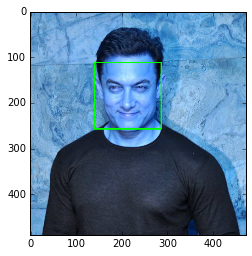

In [28]:
# WARNING : cascade XML file from this repo : https://github.com/shantnu/FaceDetect.git
faceCascade = cv2.CascadeClassifier("haarcascade_frontalface_default.xml")

# Read the image
image = cv2.imread(imagePath)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Detect faces in the image
faces = faceCascade.detectMultiScale(
    gray,
    scaleFactor=1.1,
    minNeighbors=5,
    minSize=(30, 30)
)
faces = faceCascade.detectMultiScale(gray, 1.2, 5)

print "Found {0} faces!".format(len(faces))

# Draw a rectangle around the faces
for (x, y, w, h) in faces:
    cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), 2)

plt.imshow(image)

(2, u'Aamir_Khan', 0.99999928, [4.5765095e-18, 0.99999928])
(2, u'Aamir_Khan', 0.99956626, [9.5246944e-12, 0.99956626])


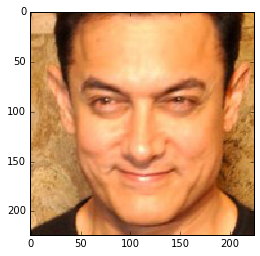

In [29]:
im = Image.open(imagePath)

(x, y, w, h) = faces[0]
center_x = x+w/2
center_y = y+h/2
b_dim = min(max(w,h)*1.2,im.width, im.height) # WARNING : this formula in incorrect
#box = (x, y, x+w, y+h)
box = (center_x-b_dim/2, center_y-b_dim/2, center_x+b_dim/2, center_y+b_dim/2)
# Crop Image
crpim = im.crop(box).resize((224,224))
plt.imshow(np.asarray(crpim))

pred(facemodel, crpim, transform=False)
pred(facemodel, crpim, transform=True)